# How to Tune Models like a Puppet-master Based on Confusion Matrix
## Learn to control model output based on what's important to the problem using a confusion matrix

![](./images/pixabay.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://pixabay.com/users/tskirde-3014515/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=1594638'>Thomas Skirde</a>
        on 
        <a href='https://pixabay.com/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=1594638'>Pixabay</a>
    </strong>
</figcaption>

### Setup

In [266]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["figure.figsize"] = [12, 9]
rcParams["xtick.labelsize"] = 15
rcParams["ytick.labelsize"] = 15
rcParams["font.size"] = 15
warnings.filterwarnings("ignore")

### Introduction  TODO

Classification is a huge part of machine learning. Its benefits and applications are endless - ranging from detecting new asteroids and planets to identifying cancerous cells are all done using classification algorithms. 

The type of the problems classification solves is divided into two: unsupervised and supervised. Unsupervised models are called neural networks and they can be trained on unstructured data such as video, audio and images. In contrast, supervised models work with labeled, tabular data and is part of classic machine learning. The focus of this article is the latter, particularly, we will be exploring what all supervised classification problems have in common: *confusion matrices*.

### Developing a Classification Preprocessing Pipeline

A good model needs good data. So, it is important to process the available information as much as possible to achieve best model performance even before tuning it based on confusion matrices. 

A typical preprocessing workflow includes dealing with missing values, scaling/normalizing numeric features, encoding categorical variables and do all other feature engineering steps required. We will see an example of this in this section.

We will be predicting credit card approvals using the [Credit Card Approval Dataset](http://archive.ics.uci.edu/ml/datasets/credit+approval) from UCI Machine Learning Repository. Before banks can issue credit cards to new customers, there are many factors to consider: income levels, loan balances, individual's credit report, etc. This is often a difficult and mundane task, so nowadays banks use ML algorithms. Let's take a peek at the data:

In [267]:
import pandas as pd

df = pd.read_csv("data/cc_approvals.data", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


Since it is private data, the feature names are left blank. Let's fix that first:

In [268]:
df.columns = ["feature_" + str(col) for col in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_0   690 non-null    object 
 1   feature_1   690 non-null    object 
 2   feature_2   690 non-null    float64
 3   feature_3   690 non-null    object 
 4   feature_4   690 non-null    object 
 5   feature_5   690 non-null    object 
 6   feature_6   690 non-null    object 
 7   feature_7   690 non-null    float64
 8   feature_8   690 non-null    object 
 9   feature_9   690 non-null    object 
 10  feature_10  690 non-null    int64  
 11  feature_11  690 non-null    object 
 12  feature_12  690 non-null    object 
 13  feature_13  690 non-null    object 
 14  feature_14  690 non-null    int64  
 15  feature_15  690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


The dataset contains both numeric and categorical features. The missing values in this dataset are encoded with question marks (?). We will replace them with `NaN`s:

In [269]:
import numpy as np

df = df.replace("?", np.nan).copy()

df.isnull().sum()

feature_0     12
feature_1     12
feature_2      0
feature_3      6
feature_4      6
feature_5      9
feature_6      9
feature_7      0
feature_8      0
feature_9      0
feature_10     0
feature_11     0
feature_12     0
feature_13    13
feature_14     0
feature_15     0
dtype: int64

Features 0, 1, 3, 4, 5, 6 and 13 contain missing values. Inspecting the data, we may guess that feature 13 contains zipcodes, so we can drop it. And for others, since they make up less than the 5% of the dataset, we can drop those rows:

In [270]:
# Drop zipcode col
df.drop("feature_13", axis=1, inplace=True)

# Drop rows with NaNs
df.dropna(how="any", inplace=True)

df.shape

(659, 15)

We did not use any imputation techniques because of the low number of nulls. If you want to know about robust imputation techniques, this article will help:

https://towardsdatascience.com/going-beyond-the-simpleimputer-for-missing-data-imputation-dd8ba168d505?source=your_stories_page-------------------------------------

Let's focus on numeric values now. Specifically, we will look at their distributions:

In [271]:
df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
feature_2,659.0,4.852,5.020,0.0,1.040,2.875,7.520,28.0
feature_7,659.0,2.251,3.383,0.0,0.165,1.000,2.625,28.5
feature_10,659.0,2.499,4.952,0.0,0.000,0.000,3.000,67.0
feature_14,659.0,1046.024,5324.983,0.0,0.000,5.000,400.000,100000.0


All features have a minimum of 0 but they are all on different scales. This means we have to use some type of normalization and we will see what kind by exploring these features visually:

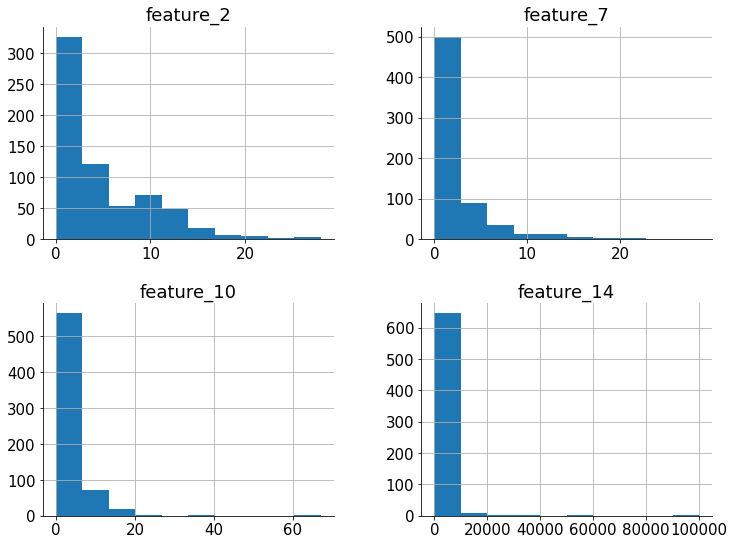

In [272]:
import seaborn as sns

df.hist();

Features have skewed distributions which means, we will perform non-linear transform such as `PowerTransformer` (uses logarithms under the hood):

In [273]:
# Store the cols to be log transformed
to_log = df.select_dtypes(include="number").columns.to_list()
to_log

['feature_2', 'feature_7', 'feature_10', 'feature_14']

If you want to know more about other numeric feature transformation techniques, I got that covered too:
https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94?source=your_stories_page-------------------------------------

To encode categorical features, we will use a `OneHotEncoder`. Before isolating the columns to be used in encoding, let's separate the data into feature and target arrays:

In [274]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]  # the last column is the target

Now, isolate the categorical columns to be OH encoded:

In [275]:
categorical_cols = X.select_dtypes(include="object").columns.to_list()

Finally, we will build the preprocessing pipeline:

> If you are not familiar with Sklearn pipelines and column transformers, I recommend reading this post:
https://towardsdatascience.com/how-to-use-sklearn-pipelines-for-ridiculously-neat-code-a61ab66ca90d

In [276]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PowerTransformer

# Create a col_transformer object
col_transformer = ColumnTransformer(
    transformers=[
        ("log", PowerTransformer(), to_log),
        (
            "oh_encode",
            OneHotEncoder(sparse=False, handle_unknown="ignore"),
            categorical_cols,
        ),
    ]
)

# Combine into a final pipeline
pipeline = Pipeline(
    steps=[("preprocess", col_transformer), ("base_model", RandomForestClassifier())]
)

# Encode the target manually to encode the positive class
y = y.map({"+": "Approved", "-": "Rejected"})

### Intro to the Confusion Matrix

At the last step, I added a `RandomForestClassifier` to the pipeline as a base model. We want the model to predict approved applications more accurately because that would mean more customers to the bank. This would also make the approved applications a *positive class* in our predictions. Let's finally evaluate the pipeline:

In [277]:
from sklearn.model_selection import train_test_split

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# Fit/score the pipeline
pipeline.fit(X_train, y_train)
print(f"RandomForest pipeline scored {pipeline.score(X_test, y_test).round(3)}")

RandomForest pipeline scored 0.894


The default scoring of all classifiers is the accuracy score, which our base pipeline impressively achieved ~89%. 

But, here is the problem with accuracy - what is the model *accurate* at? Can it predict suitable applications better or is it more accurate at detecting undesirable candidates? From a business perspective, your results should be able to answer both questions and accuracy does not do that. 

As a solution, let's finally get introduced to a confusion matrix:

In [278]:
from sklearn.metrics import confusion_matrix

# Generate predictions
y_pred = pipeline.predict(X_test)

# Create the confusion matrix
confusion_matrix(y_test, y_pred)

array([[84,  6],
       [15, 93]], dtype=int64)

Since, it is a binary classification problem, the matrix is of shape 2 by 2 (there are two classes in the target). The diagonal of the matrix shows the number of correctly classified samples and the off-diagonal cells shows where the model made a mistake. To further understand this, Sklearn provides a visual matrix, which is much better:

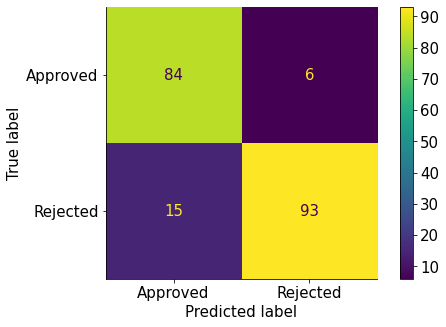

In [279]:
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(
    pipeline,  # Fitted estimator (it must have been fit)
    X_test,
    y_test,  # test sets
    ax=ax,
);

This confusion matrix is much more informative. Here are a few things to notice:
- The rows correspond to the actual values 
- The columns correspond to the predicted values
- Each cell is a count of each true/predicted value combination

Paying attention to the axes labels, the first row represents the actual positive class (approved applications) while second row is for the actual negative class. Similarly, the first column is for the positive predicted and the second for negative predicted. 

However, this format of confusion only occurs in Sklearn API. Most other literature you will see will construct the matrix with predictions as rows and actual values as columns. Therefore, it would be less confusing to bring the matrix into a proper format.

Unfortunately, `plot_confusion_matrix` does not allow that. Instead, we will use another Sklearn function that allows plotting custom matrices called `ConfusionMatrixDisplay`:

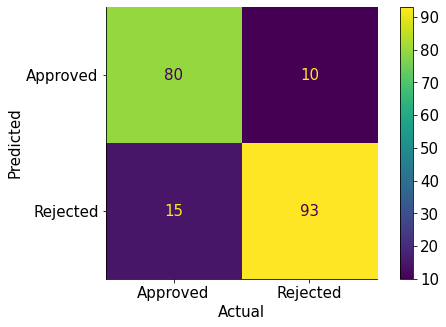

In [260]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay


def inverted_confusion_matrix(y_true, y_pred, display_labels=None):
    """
    A function to display standard Sklearn confusion matrices
    in an inverted format
    """
    # Create an inverted matrix
    cm = np.flip(confusion_matrix(y_true, y_pred))
    # Create the plot
    cmp = ConfusionMatrixDisplay(cm, display_labels=display_labels)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp.plot(ax=ax)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")


inverted_confusion_matrix(y_test, y_pred, display_labels=["Approved", "Rejected"])

It accepts a useful parameter to control the label names. Most importantly, we are passing an inverted matrix to the `ConfusionMatrixDisplay` function using the `np.flip` function.

Let's finally interpret this matrix:

- **(top left)** - there were 76 applications which were actually *approved* and the model *correctly* classified them *approved* as well
- **(bottom right)** - there were 97 applications which were actually *rejected* and the model *correctly* classified them *rejected* as well
- **(bottom left)** - there were 11 applications which were actually *rejected* but the model *incorrectly* classified them as *approved*
- **(top right)** - there were 14 applications which were actually *approved* but the model *incorrectly* classified them as *rejected*.


Since these confusion matrices are used all the time in classification, each cell has its own proper name:

- **(top left)** - *True Positives (TP)*, actual positive, predicted positive (76)
- **(bottom right)** - *True Negatives (TN)*, actual negative, predicted negative (97)
- **(bottom left)** - *False Positive (FP)*, actual negative, predicted positive (11)
- **(top right)** - *False Negative (FN)*, actual positive, predicted negative (14)

No matter how the confusion matrix is represented, the idea is always the same. That's why it will be useful to spend a few minutes to construct the matrix beforehand and point out what its cells represent in words. You can also use the `.ravel()` method on a confusion matrix if you get *confused*😊:

In [257]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(93, 15, 10, 80)

### Precision, Recall and F scores

In this section, we will learn about further metrics that lets us compare one confusion matrix to another or in other words, how to compare one model to another. Let's say we have another pipeline with `LogisticRegression` as a classifier:

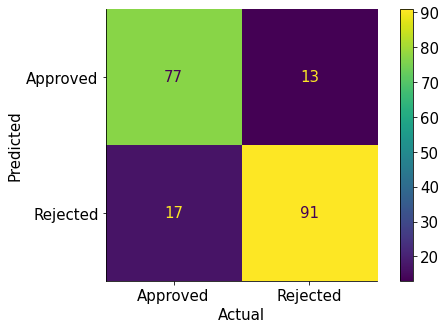

In [258]:
from copy import deepcopy

from sklearn.linear_model import LogisticRegression

# Copy the pipeline to edit the estimator
logreg_pipeline = deepcopy(pipeline)
logreg_pipeline.steps[1] = ("base_model", LogisticRegression())

# Fit/predict the logreg pipeline
logreg_pipeline.fit(X_train, y_train)
y_pred_logistic = logreg_pipeline.predict(X_test)

# Plot the confusion matrix
inverted_confusion_matrix(
    y_test, y_pred_logistic, display_labels=["Approved", "Rejected"]
)

### ADD THE SECOND MATIX FOR COMPARISON

Looking at the plot above, we might say the results of both Random Forests and Logistic Regression are similar. However, there are 3 more metrics we can derive from the confusion matrix that lets us further compare them:

1. 

In [241]:
sklearn.metrics.SCORERS.keys()

<IPython.core.display.Javascript object>

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei